In [42]:
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as K

import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
from keras import layers
from tensorflow import data
from tensorflow.python.util.tf_export import tf_export
from keras.utils import to_categorical

In [27]:
labellist=['label']
covlist=['subject1','Female','Age','k1a','k2a','k3a','Mono','Gran','CD4T','NK','CD8_naive','CD8pCD28nCD45RAn','PlasmaBlast']
snplist=['subject1','GSA-rs2294942_G','rs1939015_G','rs3762352_C','rs525157_A','rs72660967_T','rs6142884_A']
cpglist=['subject1','cg25929399','cg05704942','cg10306192','cg24088508','cg20089799','cg06961873','cg00704664','cg06961873']
featurelist = covlist+snplist+cpglist
fulllist = featurelist+labellist
# print('covlist',covlist)
shuffle_buffer = 500
sample_size = 551
repeats = 10
batch_size = 200
train_batches = 3


# open the serialized schema for the binary data input file
with open("../data/feature_dict.pkl", "rb") as f:
    peg_header_dict = pickle.load(f)
peg_header_dict_subset = {}
for f in fulllist:
    if f in peg_header_dict:
        peg_header_dict_subset[f] = peg_header_dict[f]
        
print('dictionary for tfrecord:',peg_header_dict_subset)


dictionary for tfrecord: {'subject1': FixedLenFeature(shape=[], dtype=tf.string, default_value=''), 'Female': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'Age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'k1a': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'k2a': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'k3a': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'Mono': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'Gran': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'CD4T': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'NK': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'CD8_naive': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'CD8pCD28nCD45RAn': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'PlasmaBlast': FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0), 'GSA-rs2294942_G

In [28]:

# Sample string labels
labels = ['cases','controls']

feature_description = peg_header_dict_subset
def parse_single(example_proto,sublist):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    diction = tf.io.parse_single_example(example_proto, feature_description)
    # convert label to a float
    label = diction['label']
    intlabel = tf.constant(0.0,dtype='float32')
    if label=='cases':
        intlabel = tf.constant(1.0,dtype='float32')
    diction['label'] = intlabel
    filteredlist = {key:diction[key] for key in sublist}
    return filteredlist

def floatcaster(features):
    casted = [tf.cast(features[column], tf.float32)  for column in features if tf.debugging.is_numeric_tensor(features[column])]
    #print('casted',casted)
    features = tf.concat(  tf.transpose(casted), 1)    
    return features
  
def parse_batched(features,covlist,snplist,cpglist,labellist):
    feature_dict = {}
    feature_dict['cov_input'] = floatcaster( {key:features[key] for key in covlist} )
    feature_dict['snp_input'] = floatcaster( {key:features[key] for key in snplist} )
    feature_dict['cpg_input'] = floatcaster( {key:features[key] for key in cpglist} )
    labels = features[labellist[0]]
    return (feature_dict,labels)
    



In [29]:
filenames = ['../data/dataset.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
full_dataset = raw_dataset.map(lambda x: parse_single(x,featurelist+labellist))
#print('full',full_dataset)

batched_dataset = full_dataset.repeat().shuffle(shuffle_buffer).batch(batch_size).map(lambda features:parse_batched(features,covlist,snplist,cpglist,labellist))
#print('batched2',next(iter(batched_dataset2)))
train = batched_dataset.take(train_batches)
val = batched_dataset.skip(train_batches)

print('cov dim',train.element_spec[0]['cov_input'].shape[1])
print('snp dim',train.element_spec[0]['snp_input'].shape[1])
print('cpg dim',train.element_spec[0]['cpg_input'].shape[1])
#print('training sample',next(iter(train)))

cov dim 12
snp dim 6
cpg dim 7


In [51]:
@tf_export('keras.layers.MaskedDense')
class MaskedDense(layers.Layer):
    def __init__(self, units, mask, **kwargs):
        super(MaskedDense, self).__init__(**kwargs)
        self.units = units
        self.mask = mask  # Mask should be a numpy array or a tensor

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        super(MaskedDense, self).build(input_shape)

    def call(self, inputs):
        masked_kernel = self.kernel * tf.cast(self.mask, self.kernel.dtype)
        output = tf.matmul(inputs, masked_kernel)
        output = tf.nn.bias_add(output, self.bias)
        return output

    def get_config(self):
        config = super(MaskedDense, self).get_config()
        config.update({
            'units': self.units,
            'mask': self.mask.tolist() if hasattr(self.mask, 'tolist') else self.mask,  # Handle numpy arrays or tensors
        })
        return config

    @classmethod
    def from_config(cls, config):
        mask = config.pop('mask')
        return cls(mask=mask, **config)
mask = np.zeros((4,3))
mask[2,2] = 1
layer = MaskedDense(units=3,mask=mask)
print('layer',layer)
print('config',layer.get_config())

layer <MaskedDense name=masked_dense_14, built=False>
config {'name': 'masked_dense_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 3, 'mask': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]}


In [53]:
def create_cov_model(dataset):
    input_dim = dataset.element_spec[0]['cov_input'].shape[1]
    print('inputsize',input_dim)    
    inputs = layers.Input(shape=(input_dim,),name='cov_input')
    x = layers.Dense(1,name='cov_output')(inputs)
    return keras.models.Model(inputs,x,name='cov_model')
cov_model =create_cov_model(train)
print(cov_model.summary())

def create_snp_model(dataset):
    input_dim = dataset.element_spec[0]['snp_input'].shape[1]
    print('inputsize',input_dim)    
    output_dim = 5
    mask = np.zeros((input_dim,output_dim))
    mask[2,2] = 1
    inputs = layers.Input(shape=(input_dim,),name='snp_input')
    x = MaskedDense(units=output_dim,mask=mask)(inputs)
    x = layers.Flatten()(x)
    #x = layers.Dense(5,name='snp_gene')(inputs)
    x = layers.Dense(1,name='snp_gene_output')(x)
    return keras.models.Model(inputs,x,name='snp_model')
snp_model = create_snp_model(train)
print(snp_model.summary())

def create_cpg_model(dataset):
    input_dim = dataset.element_spec[0]['cpg_input'].shape[1]
    print('inputsize',input_dim)    
    inputs = layers.Input(shape=(input_dim,),name='cpg_input')
    x = layers.Dense(5,name='cpg_gene')(inputs)
    x = layers.Dense(1,name='cpg_gene_output')(x)
    return keras.models.Model(inputs,x,name='cpg_model')
cpg_model = create_cpg_model(train)
print(cpg_model.summary())

def create_pathway_model(cov_model,snp_model,cpg_model):
    pathwayInput = layers.concatenate([snp_model.output,cpg_model.output],name='pathway_input')
    x = layers.Dense(4,name='pathway_level_1')(pathwayInput)
    x = layers.Dense(3,name='pathway_level_2')(x)K.bias_add
    x = layers.concatenate([cov_model.output,x],name='pathway_output')
    x = layers.Dense(1)(x)
    #return keras.models.Model(inputs=[cov_model.input,snp_model.input,cpg_model.input],outputs=x)
    return keras.models.Model(inputs={'cov_input':cov_model.input,'snp_input':snp_model.input,'cpg_input':cpg_model.input},outputs=x,name='pathway_model')
pathway_model = create_pathway_model(cov_model,snp_model,cpg_model)

print('Pathway model inputs:',pathway_model.inputs)
print('Pathway model architecture',pathway_model.summary())

inputsize 12


Model: "cov_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cov_input (InputLayer)          │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cov_output (Dense)              │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

None
inputsize 6


Model: "snp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ snp_input (InputLayer)          │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_dense_16 (MaskedDense)   │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ snp_gene_output (Dense)         │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

None
inputsize 7


Model: "cpg_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cpg_input (InputLayer)          │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cpg_gene (Dense)                │ (None, 5)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cpg_gene_output (Dense)         │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46 (184.00 B)

 Trainable params: 46 (184.00 B)

 Non-trainable params: 0 (0.00 B)

None
Pathway model inputs: [<KerasTensor shape=(None, 12), dtype=float32, sparse=False, ragged=False, name=cov_input>, <KerasTensor shape=(None, 7), dtype=float32, sparse=False, ragged=False, name=cpg_input>, <KerasTensor shape=(None, 6), dtype=float32, sparse=False, ragged=False, name=snp_input>]


Model: "pathway_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ snp_input           │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_dense_16     │ (None, 5)         │         35 │ snp_input[0][0]   │
│ (MaskedDense)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cpg_input           │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 5)         │          0 │ masked_dense_16[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cpg_gene (Dense)    │ (None, 5)         │         40 │ cpg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ snp_gene_output     │ (None, 1)         │          6 │ flatten_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cpg_gene_output     │ (None, 1)         │          6 │ cpg_gene[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pathway_input       │ (None, 2)         │          0 │ snp_gene_output[… │
│ (Concatenate)       │                   │            │ cpg_gene_output[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pathway_level_1     │ (None, 4)         │         12 │ pathway_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_output (Dense)  │ (None, 1)         │         13 │ cov_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pathway_level_2     │ (None, 3)         │         15 │ pathway_level_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pathway_output      │ (None, 4)         │          0 │ cov_output[0][0], │
│ (Concatenate)       │                   │            │ pathway_level_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          5 │ pathway_output[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 132 (528.00 B)

 Trainable params: 132 (528.00 B)

 Non-trainable params: 0 (0.00 B)

Pathway model architecture None


In [54]:
#print(next(iter(cov_train)).numpy())
pathway_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

rfrun_path = '../output/'
csv_logger = K.callbacks.CSVLogger(rfrun_path + 'log.csv', append=True, separator=';')
earlystop =K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=25, verbose=1, mode='auto')
saveBestModel = K.callbacks.ModelCheckpoint(rfrun_path + "bestweight_job.h5", monitor='val_loss',
                                          verbose=1, save_best_only=True, mode='auto')
reduce_lr = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)


history = pathway_model.fit(train ,validation_data=val,steps_per_epoch=10,validation_steps=10,epochs=20,verbose=1,callbacks=[earlystop, saveBestModel, csv_logger, reduce_lr])

Epoch 1/20


2025-06-09 14:23:55.597578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 184 of 500
2025-06-09 14:24:08.715414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


KeyboardInterrupt: 

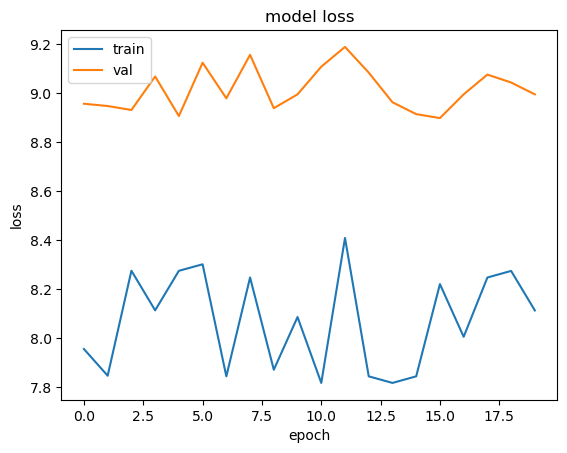

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()